In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/flower-classification-with-tpus/sample_submission.csv
/kaggle/input/flower-classification-with-tpus/tfrecords-jpeg-224x224/val/09-224x224-232.tfrec
/kaggle/input/flower-classification-with-tpus/tfrecords-jpeg-224x224/val/14-224x224-232.tfrec
/kaggle/input/flower-classification-with-tpus/tfrecords-jpeg-224x224/val/01-224x224-232.tfrec
/kaggle/input/flower-classification-with-tpus/tfrecords-jpeg-224x224/val/13-224x224-232.tfrec
/kaggle/input/flower-classification-with-tpus/tfrecords-jpeg-224x224/val/00-224x224-232.tfrec
/kaggle/input/flower-classification-with-tpus/tfrecords-jpeg-224x224/val/07-224x224-232.tfrec
/kaggle/input/flower-classification-with-tpus/tfrecords-jpeg-224x224/val/12-224x224-232.tfrec
/kaggle/input/flower-classification-with-tpus/tfrecords-jpeg-224x224/val/11-224x224-232.tfrec
/kaggle/input/flower-classification-with-tpus/tfrecords-jpeg-224x224/val/05-224x224-232.tfrec
/kaggle/input/flower-classification-with-tpus/tfrecords-jpeg-224x224/val/04-224x224-23

In [2]:
!pip install -q efficientnet


[notice] A new release of pip is available: 23.0.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip


In [3]:
import math, re, os
import tensorflow as tf, tensorflow.keras.backend as K
import numpy as np
from matplotlib import pyplot as plt
from kaggle_datasets import KaggleDatasets
import efficientnet.tfkeras as efn2
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix
from tensorflow.keras.applications import DenseNet201
print("Tensorflow version " + tf.__version__)


Tensorflow version 2.14.0


# Configurations

In [14]:
AUTO = tf.data.experimental.AUTOTUNE

# Create strategy from tpu
tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)
strategy = tf.distribute.experimental.TPUStrategy(tpu)

# Data access
GCS_DS_PATH = KaggleDatasets().get_gcs_path()

# Configuration
IMAGE_SIZE = [512, 512]
EPOCHS = 2
BATCH_SIZE = 16 * strategy.num_replicas_in_sync

INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Initializing the TPU system: local


INFO:tensorflow:Initializing the TPU system: local


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)
get_gcs_path is not required on TPU VMs which can directly use Kaggle datasets, using path: /kaggle/input/flower-classification-with-tpus


# Custom LR schedule

Learning rate schedule: 1e-05 to 8.8e-05 to 8.8e-05


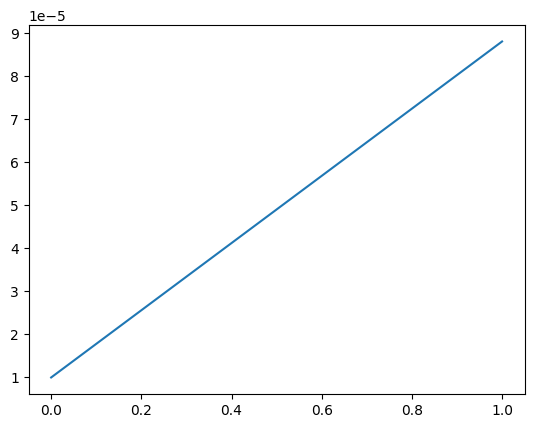

In [15]:
LR_START = 0.00001
LR_MAX = 0.00005 * strategy.num_replicas_in_sync
LR_MIN = 0.00001
LR_RAMPUP_EPOCHS = 5
LR_SUSTAIN_EPOCHS = 0
LR_EXP_DECAY = .8

def lrfn(epoch):
    if epoch < LR_RAMPUP_EPOCHS:
        lr = (LR_MAX - LR_START) / LR_RAMPUP_EPOCHS * epoch + LR_START
    elif epoch < LR_RAMPUP_EPOCHS + LR_SUSTAIN_EPOCHS:
        lr = LR_MAX
    else:
        lr = (LR_MAX - LR_MIN) * LR_EXP_DECAY**(epoch - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS) + LR_MIN
    return lr
    
lr_callback = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose=True)

rng = [i for i in range(EPOCHS)]
y = [lrfn(x) for x in rng]
plt.plot(rng, y)
print("Learning rate schedule: {:.3g} to {:.3g} to {:.3g}".format(y[0], max(y), y[-1]))

In [16]:
GCS_PATH_SELECT = { # available image sizes
    192: GCS_DS_PATH + '/tfrecords-jpeg-192x192',
    224: GCS_DS_PATH + '/tfrecords-jpeg-224x224',
    331: GCS_DS_PATH + '/tfrecords-jpeg-331x331',
    512: GCS_DS_PATH + '/tfrecords-jpeg-512x512'
}
GCS_PATH = GCS_PATH_SELECT[IMAGE_SIZE[0]]

TRAINING_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/train/*.tfrec')
VALIDATION_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/val/*.tfrec')
TEST_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/test/*.tfrec') # predictions on this dataset should be submitted for the competition

# watch out for overfitting!
SKIP_VALIDATION = True
if SKIP_VALIDATION:
    TRAINING_FILENAMES = TRAINING_FILENAMES + VALIDATION_FILENAMES
## V20  
# VALIDATION_MISMATCHES_IDS = ['861282b96','df1fd14b4','b402b6acd','741999f79','4dab7fa08','6423cd23e','617a30d60','87d91aefb','2023d3cac','5f56bcb7f','4571b9509','f4ec48685','f9c50db87','96379ff01','28594d9ce','6a3a28a06','fbd61ef17','55a883e16','83a80db99','9ee42218f','b5fb20185','868bf8b0c','d0caf04b9','ef945a176','9b8f2f5bd','f8da3867d','0bf0b39b3','bab3ef1f5','293c37e25','f739f3e83','5253af526','f27f9a100','077803f97','b4becad84']
## V22
# VALIDATION_MISMATCHES_IDS = ['861282b96','617a30d60','4571b9509','f4ec48685','28594d9ce','6a3a28a06','55a883e16','9b8f2f5bd','293c37e25']
## V23
VALIDATION_MISMATCHES_IDS = []

In [17]:
CLASSES = ['pink primrose',    'hard-leaved pocket orchid', 'canterbury bells', 'sweet pea',     'wild geranium',     'tiger lily',           'moon orchid',              'bird of paradise', 'monkshood',        'globe thistle',         # 00 - 09
           'snapdragon',       "colt's foot",               'king protea',      'spear thistle', 'yellow iris',       'globe-flower',         'purple coneflower',        'peruvian lily',    'balloon flower',   'giant white arum lily', # 10 - 19
           'fire lily',        'pincushion flower',         'fritillary',       'red ginger',    'grape hyacinth',    'corn poppy',           'prince of wales feathers', 'stemless gentian', 'artichoke',        'sweet william',         # 20 - 29
           'carnation',        'garden phlox',              'love in the mist', 'cosmos',        'alpine sea holly',  'ruby-lipped cattleya', 'cape flower',              'great masterwort', 'siam tulip',       'lenten rose',           # 30 - 39
           'barberton daisy',  'daffodil',                  'sword lily',       'poinsettia',    'bolero deep blue',  'wallflower',           'marigold',                 'buttercup',        'daisy',            'common dandelion',      # 40 - 49
           'petunia',          'wild pansy',                'primula',          'sunflower',     'lilac hibiscus',    'bishop of llandaff',   'gaura',                    'geranium',         'orange dahlia',    'pink-yellow dahlia',    # 50 - 59
           'cautleya spicata', 'japanese anemone',          'black-eyed susan', 'silverbush',    'californian poppy', 'osteospermum',         'spring crocus',            'iris',             'windflower',       'tree poppy',            # 60 - 69
           'gazania',          'azalea',                    'water lily',       'rose',          'thorn apple',       'morning glory',        'passion flower',           'lotus',            'toad lily',        'anthurium',             # 70 - 79
           'frangipani',       'clematis',                  'hibiscus',         'columbine',     'desert-rose',       'tree mallow',          'magnolia',                 'cyclamen ',        'watercress',       'canna lily',            # 80 - 89
           'hippeastrum ',     'bee balm',                  'pink quill',       'foxglove',      'bougainvillea',     'camellia',             'mallow',                   'mexican petunia',  'bromelia',         'blanket flower',        # 90 - 99
           'trumpet creeper',  'blackberry lily',           'common tulip',     'wild rose']                                                                                                                                               # 100 - 102

# Helper Functions
## Visualization

In [18]:
# numpy and matplotlib defaults
np.set_printoptions(threshold=15, linewidth=80)

def batch_to_numpy_images_and_labels(data):
    images, labels = data
    numpy_images = images.numpy()
    numpy_labels = labels.numpy()
    if numpy_labels.dtype == object: # binary string in this case, these are image ID strings
        numpy_labels = [None for _ in enumerate(numpy_images)]
    # If no labels, only image IDs, return None for labels (this is the case for test data)
    return numpy_images, numpy_labels

def title_from_label_and_target(label, correct_label):
    if correct_label is None:
        return CLASSES[label], True
    correct = (label == correct_label)
    return "{} [{}{}{}]".format(CLASSES[label], 'OK' if correct else 'NO', u"\u2192" if not correct else '',
                                CLASSES[correct_label] if not correct else ''), correct

def display_one_flower(image, title, subplot, red=False, titlesize=16):
    plt.subplot(*subplot)
    plt.axis('off')
    plt.imshow(image)
    if len(title) > 0:
        plt.title(title, fontsize=int(titlesize) if not red else int(titlesize/1.2), color='red' if red else 'black', fontdict={'verticalalignment':'center'}, pad=int(titlesize/1.5))
    return (subplot[0], subplot[1], subplot[2]+1)
    
def display_batch_of_images(databatch, predictions=None, figsize  = 13.0):
    """This will work with:
    display_batch_of_images(images)
    display_batch_of_images(images, predictions)
    display_batch_of_images((images, labels))
    display_batch_of_images((images, labels), predictions)
    """
    # data
    images, labels = batch_to_numpy_images_and_labels(databatch)
    if labels is None:
        labels = [None for _ in enumerate(images)]
        
    # auto-squaring: this will drop data that does not fit into square or square-ish rectangle
    rows = int(math.sqrt(len(images)))
    cols = len(images)//rows
        
    # size and spacing
    FIGSIZE =  figsize
    SPACING = 0.1
    subplot=(rows,cols,1)
    if rows < cols:
        plt.figure(figsize=(FIGSIZE,FIGSIZE/cols*rows))
    else:
        plt.figure(figsize=(FIGSIZE/rows*cols,FIGSIZE))
    
    # display
    for i, (image, label) in enumerate(zip(images[:rows*cols], labels[:rows*cols])):
        title = '' if label is None else CLASSES[label]
        correct = True
        if predictions is not None:
            title, correct = title_from_label_and_target(predictions[i], label)
        dynamic_titlesize = FIGSIZE*SPACING/max(rows,cols)*40+3 # magic formula tested to work from 1x1 to 10x10 images
        subplot = display_one_flower(image, title, subplot, not correct, titlesize=dynamic_titlesize)
    
    #layout
    plt.tight_layout()
    if label is None and predictions is None:
        plt.subplots_adjust(wspace=0, hspace=0)
    else:
        plt.subplots_adjust(wspace=SPACING, hspace=SPACING)
    plt.show()

def display_confusion_matrix(cmat, score, precision, recall):
    plt.figure(figsize=(15,15))
    ax = plt.gca()
    ax.matshow(cmat, cmap='Reds')
    ax.set_xticks(range(len(CLASSES)))
    ax.set_xticklabels(CLASSES, fontdict={'fontsize': 7})
    plt.setp(ax.get_xticklabels(), rotation=45, ha="left", rotation_mode="anchor")
    ax.set_yticks(range(len(CLASSES)))
    ax.set_yticklabels(CLASSES, fontdict={'fontsize': 7})
    plt.setp(ax.get_yticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    titlestring = ""
    if score is not None:
        titlestring += 'f1 = {:.3f} '.format(score)
    if precision is not None:
        titlestring += '\nprecision = {:.3f} '.format(precision)
    if recall is not None:
        titlestring += '\nrecall = {:.3f} '.format(recall)
    if len(titlestring) > 0:
        ax.text(101, 1, titlestring, fontdict={'fontsize': 18, 'horizontalalignment':'right', 'verticalalignment':'top', 'color':'#804040'})
    plt.show()
    
def display_training_curves(training, validation, title, subplot):
    if subplot%10==1: # set up the subplots on the first call
        plt.subplots(figsize=(10,10), facecolor='#F0F0F0')
        plt.tight_layout()
    ax = plt.subplot(subplot)
    ax.set_facecolor('#F8F8F8')
    ax.plot(training)
    ax.plot(validation)
    ax.set_title('model '+ title)
    ax.set_ylabel(title)
    #ax.set_ylim(0.28,1.05)
    ax.set_xlabel('epoch')
    ax.legend(['train', 'valid.'])

# Data Augmentation

In [19]:
def get_mat(rotation, shear, height_zoom, width_zoom, height_shift, width_shift):
    # returns 3x3 transformmatrix which transforms indicies
        
    # CONVERT DEGREES TO RADIANS
    rotation = math.pi * rotation / 180.
    shear = math.pi * shear / 180.
    
    # ROTATION MATRIX
    c1 = tf.math.cos(rotation)
    s1 = tf.math.sin(rotation)
    one = tf.constant([1],dtype='float32')
    zero = tf.constant([0],dtype='float32')
    rotation_matrix = tf.reshape( tf.concat([c1,s1,zero, -s1,c1,zero, zero,zero,one],axis=0),[3,3] )
        
    # SHEAR MATRIX
    c2 = tf.math.cos(shear)
    s2 = tf.math.sin(shear)
    shear_matrix = tf.reshape( tf.concat([one,s2,zero, zero,c2,zero, zero,zero,one],axis=0),[3,3] )    
    
    # ZOOM MATRIX
    zoom_matrix = tf.reshape( tf.concat([one/height_zoom,zero,zero, zero,one/width_zoom,zero, zero,zero,one],axis=0),[3,3] )
    
    # SHIFT MATRIX
    shift_matrix = tf.reshape( tf.concat([one,zero,height_shift, zero,one,width_shift, zero,zero,one],axis=0),[3,3] )
    
    return K.dot(K.dot(rotation_matrix, shear_matrix), K.dot(zoom_matrix, shift_matrix))

def transform(image,label):
    # input image - is one image of size [dim,dim,3] not a batch of [b,dim,dim,3]
    # output - image randomly rotated, sheared, zoomed, and shifted
    DIM = IMAGE_SIZE[0]
    XDIM = DIM%2 #fix for size 331
    
    rot = 15. * tf.random.normal([1],dtype='float32')
    shr = 5. * tf.random.normal([1],dtype='float32') 
    h_zoom = 1.0 + tf.random.normal([1],dtype='float32')/10.
    w_zoom = 1.0 + tf.random.normal([1],dtype='float32')/10.
    h_shift = 16. * tf.random.normal([1],dtype='float32') 
    w_shift = 16. * tf.random.normal([1],dtype='float32') 
  
    # GET TRANSFORMATION MATRIX
    m = get_mat(rot,shr,h_zoom,w_zoom,h_shift,w_shift) 

    # LIST DESTINATION PIXEL INDICES
    x = tf.repeat( tf.range(DIM//2,-DIM//2,-1), DIM )
    y = tf.tile( tf.range(-DIM//2,DIM//2),[DIM] )
    z = tf.ones([DIM*DIM],dtype='int32')
    idx = tf.stack( [x,y,z] )
    
    # ROTATE DESTINATION PIXELS ONTO ORIGIN PIXELS
    idx2 = K.dot(m,tf.cast(idx,dtype='float32'))
    idx2 = K.cast(idx2,dtype='int32')
    idx2 = K.clip(idx2,-DIM//2+XDIM+1,DIM//2)
    
    # FIND ORIGIN PIXEL VALUES           
    idx3 = tf.stack( [DIM//2-idx2[0,], DIM//2-1+idx2[1,]] )
    d = tf.gather_nd(image,tf.transpose(idx3))
        
    return tf.reshape(d,[DIM,DIM,3]),label



# Datasets Functions

In [20]:
def decode_image(image_data):
    image = tf.image.decode_jpeg(image_data, channels=3)
    image = tf.cast(image, tf.float32) / 255.0  # convert image to floats in [0, 1] range
    image = tf.reshape(image, [*IMAGE_SIZE, 3]) # explicit size needed for TPU
    return image

def read_labeled_tfrecord(example):
    LABELED_TFREC_FORMAT = {
        "image": tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring
        "class": tf.io.FixedLenFeature([], tf.int64),  # shape [] means single element
        
    }
    example = tf.io.parse_single_example(example, LABELED_TFREC_FORMAT)
    image = decode_image(example['image'])
    label = tf.cast(example['class'], tf.int32)
    return image, label # returns a dataset of (image, label) pairs

def read_unlabeled_tfrecord(example):
    UNLABELED_TFREC_FORMAT = {
        "image": tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring
        "id": tf.io.FixedLenFeature([], tf.string),  # shape [] means single element
        # class is missing, this competitions's challenge is to predict flower classes for the test dataset
    }
    example = tf.io.parse_single_example(example, UNLABELED_TFREC_FORMAT)
    image = decode_image(example['image'])
    idnum = example['id']
    return image, idnum # returns a dataset of image(s)

def read_labeled_id_tfrecord(example):
    LABELED_ID_TFREC_FORMAT = {
        "image": tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring
        "class": tf.io.FixedLenFeature([], tf.int64),  # shape [] means single element
        "id": tf.io.FixedLenFeature([], tf.string),  # shape [] means single element
    }
    example = tf.io.parse_single_example(example, LABELED_ID_TFREC_FORMAT)
    image = decode_image(example['image'])
    label = tf.cast(example['class'], tf.int32)
    idnum =  example['id']
    return image, label, idnum # returns a dataset of (image, label, idnum) triples

def load_dataset(filenames, labeled=True, ordered=False):
    # Read from TFRecords. For optimal performance, reading from multiple files at once and
    # disregarding data order. Order does not matter since we will be shuffling the data anyway.

    ignore_order = tf.data.Options()
    if not ordered:
        ignore_order.experimental_deterministic = False # disable order, increase speed

    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTO) # automatically interleaves reads from multiple files
    dataset = dataset.with_options(ignore_order) # uses data as soon as it streams in, rather than in its original order
    dataset = dataset.map(read_labeled_id_tfrecord if labeled else read_unlabeled_tfrecord, num_parallel_calls=AUTO)
    
    return dataset

def load_dataset_with_id(filenames, ordered=False):
    # Read from TFRecords. For optimal performance, reading from multiple files at once and
    # disregarding data order. Order does not matter since we will be shuffling the data anyway.

    ignore_order = tf.data.Options()
    if not ordered:
        ignore_order.experimental_deterministic = False # disable order, increase speed

    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTO) # automatically interleaves reads from multiple files
    dataset = dataset.with_options(ignore_order) # uses data as soon as it streams in, rather than in its original order
    dataset = dataset.map(read_labeled_id_tfrecord, num_parallel_calls=AUTO)
    # returns a dataset of (image, label) pairs if labeled=True or (image, id) pairs if labeled=False
    return dataset

def data_augment(image, label):
    # data augmentation. Thanks to the dataset.prefetch(AUTO) statement in the next function (below),
    # this happens essentially for free on TPU. Data pipeline code is executed on the "CPU" part
    # of the TPU while the TPU itself is computing gradients.
    image = tf.image.random_flip_left_right(image)
    #image = tf.image.random_saturation(image, 0, 2)
    return image, label   

def get_training_dataset():
    dataset = load_dataset(TRAINING_FILENAMES, labeled=True)
    dataset = dataset.filter(lambda image, label, idnum: tf.reduce_sum(tf.cast(idnum == VALIDATION_MISMATCHES_IDS, tf.int32))==0)
    dataset = dataset.map(lambda image, label, idnum: [image, label])
    dataset = dataset.map(transform, num_parallel_calls=AUTO)
    dataset = dataset.map(data_augment, num_parallel_calls=AUTO)
    dataset = dataset.repeat() # the training dataset must repeat for several epochs
    dataset = dataset.shuffle(2048)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTO) # prefetch next batch while training (autotune prefetch buffer size)
    return dataset

def get_validation_dataset(ordered=False):
    dataset = load_dataset(VALIDATION_FILENAMES, labeled=True, ordered=ordered)
    dataset = dataset.filter(lambda image, label, idnum: tf.reduce_sum(tf.cast(idnum == VALIDATION_MISMATCHES_IDS, tf.int32))==0)
    dataset = dataset.map(lambda image, label, idnum: [image, label])
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.cache()
    dataset = dataset.prefetch(AUTO) # prefetch next batch while training (autotune prefetch buffer size)
    return dataset

def get_validation_dataset_with_id(ordered=False):
    dataset = load_dataset_with_id(VALIDATION_FILENAMES, ordered=ordered)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.cache()
    dataset = dataset.prefetch(AUTO) # prefetch next batch while training (autotune prefetch buffer size)
    return dataset

def get_test_dataset(ordered=False):
    dataset = load_dataset(TEST_FILENAMES, labeled=False, ordered=ordered)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTO) # prefetch next batch while training (autotune prefetch buffer size)
    return dataset

# counting number of unique ids in dataset
def count_data_items(filenames):
    dataset = load_dataset(filenames,labeled = False)
    dataset = dataset.map(lambda image, idnum: idnum)
    dataset = dataset.filter(lambda idnum: tf.reduce_sum(tf.cast(idnum == VALIDATION_MISMATCHES_IDS, tf.int32))==0)
    uids = next(iter(dataset.batch(21000))).numpy().astype('U') 
    return len(np.unique(uids))

NUM_TRAINING_IMAGES = count_data_items(TRAINING_FILENAMES)
NUM_VALIDATION_IMAGES = (1 - SKIP_VALIDATION) * count_data_items(VALIDATION_FILENAMES)
NUM_TEST_IMAGES = count_data_items(TEST_FILENAMES)
STEPS_PER_EPOCH = NUM_TRAINING_IMAGES // BATCH_SIZE
print('Dataset: {} training images, {} validation images, {} unlabeled test images'.format(NUM_TRAINING_IMAGES, NUM_VALIDATION_IMAGES, NUM_TEST_IMAGES))

Dataset: 16465 training images, 0 validation images, 7382 unlabeled test images


## Display mismatches


In [21]:
if len(VALIDATION_MISMATCHES_IDS)>0:
    dataset = load_dataset(TRAINING_FILENAMES,labeled = True)
    dataset = dataset.filter(lambda image, label, idnum: tf.reduce_sum(tf.cast(idnum == VALIDATION_MISMATCHES_IDS, tf.int32))>0)
    dataset = dataset.map(lambda image, label, idnum: [image, label])
    imgs = next(iter(dataset.batch(len(VALIDATION_MISMATCHES_IDS))))
    display_batch_of_images(imgs)

# Training Models

## Training Model 1

**Here the custom model has been made by me, the input will be a image of size(512,512,3) as the dataset has images of same size.After that a combination of dense layers, maxpooling layers ,Flattening is done.Finally thr last layer is the classification layer where softmax function has been used to classify the images. And I added some layers such as normalization.**

In [22]:
model6 = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(512, 512, 3)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Normalization(),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),

    tf.keras.layers.Dense(len(CLASSES), activation='softmax')
])

# Compile the model
model6.compile(
    optimizer=tf.keras.optimizers.Adam(lr=0.0001),
    loss='sparse_categorical_crossentropy',
    metrics=['sparse_categorical_accuracy'])

# Print model summary
model6.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 510, 510, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 255, 255, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 253, 253, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 126, 126, 64)      0         
 g2D)                                                            
                                                                 
 normalization (Normalizati  (None, 126, 126, 64)      129       
 on)                                                             
                                                        

In [23]:
history6 = model6.fit(
    get_training_dataset(), 
    steps_per_epoch=STEPS_PER_EPOCH,
    epochs=EPOCHS, 
    callbacks=[lr_callback],
#     validation_data=None if SKIP_VALIDATION else get_validation_dataset()
    validation_data=get_validation_dataset()

)


Epoch 1: LearningRateScheduler setting learning rate to 1e-05.
Epoch 1/2
128/128 [==============================] - 1085s 8s/step - loss: 4.3426 - sparse_categorical_accuracy: 0.0612 - val_loss: 4.1976 - val_sparse_categorical_accuracy: 0.0814 - lr: 1.0000e-05

Epoch 2: LearningRateScheduler setting learning rate to 8.8e-05.
Epoch 2/2
128/128 [==============================] - 1076s 8s/step - loss: 3.8915 - sparse_categorical_accuracy: 0.1473 - val_loss: 3.5446 - val_sparse_categorical_accuracy: 0.1959 - lr: 8.8000e-05


**The model's accuracy was unsatisfactory.**

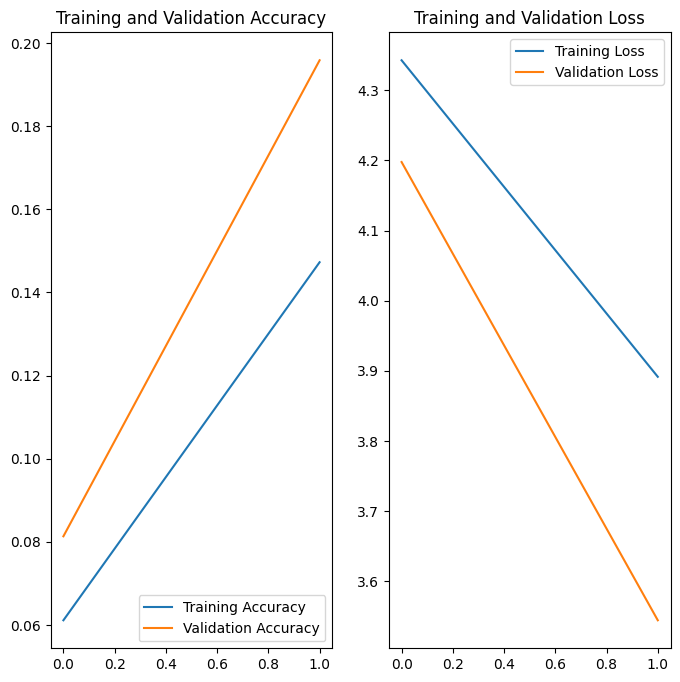

In [24]:
acc = history6.history['sparse_categorical_accuracy']
val_acc = history6.history['val_sparse_categorical_accuracy']

loss = history6.history['loss']
val_loss = history6.history['val_loss']



epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Training Model 2

**So here, the dataset has been tested with VGG19 Model.hole code has been modified by me. After that just like in previous model, validation accuracies and losses has been printed. And then finally all the results has been printed using the matplotlib.**

In [25]:
with strategy.scope():
    v19net = tf.keras.applications.VGG19(
        input_shape=(512, 512, 3),
        weights='imagenet',
        include_top=False
    )

    model4 = tf.keras.Sequential([
        v19net,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Normalization(),

        tf.keras.layers.Dense(len(CLASSES), activation='softmax')
    ])
        
model4.compile(
    optimizer=tf.keras.optimizers.Adam(lr=0.0001),
    loss = 'sparse_categorical_crossentropy',
    metrics=['sparse_categorical_accuracy']
)
model4.summary()

2023-11-11 22:05:25.675987: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-11-11 22:05:25.676128: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.


80134624/80134624 [==============================] - 0s 0us/step


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 16, 16, 512)       20024384  
                                                                 
 global_average_pooling2d (  (None, 512)               0         
 GlobalAveragePooling2D)                                         
                                                                 
 normalization_1 (Normaliza  (None, 512)               1025      
 tion)                                                           
                                                                 
 dense_3 (Dense)             (None, 104)               53352     
                                                                 
Total params: 20078761 (76.59 MB)
Trainable params: 20077736 (76.59 MB)
Non-trainable params: 1025 (4.01 KB)
_________________________________________________________________


In [26]:
history4 = model4.fit(
    get_training_dataset(), 
    steps_per_epoch=STEPS_PER_EPOCH,
    epochs=EPOCHS, 
    callbacks=[lr_callback],
#     validation_data=None if SKIP_VALIDATION else get_validation_dataset()
    validation_data=get_validation_dataset()

)


Epoch 1: LearningRateScheduler setting learning rate to 1e-05.
Epoch 1/2


2023-11-11 22:05:38.173456: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-11-11 22:05:38.191212: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-11-11 22:05:38.208221: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-11-11 22:05:38.225390: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-11-11 22:05:38.242410: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-11-11 22:05:38.259367: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-11-11 22:05:38.276359: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority un

  2/128 [..............................] - ETA: 1:39 - loss: 4.9469 - sparse_categorical_accuracy: 0.0117 

2023-11-11 22:06:05.062066: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.


  6/128 [>.............................] - ETA: 1:35 - loss: 4.8646 - sparse_categorical_accuracy: 0.0078

2023-11-11 22:06:08.204220: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.


128/128 [==============================] - ETA: 0s - loss: 4.0073 - sparse_categorical_accuracy: 0.1451

2023-11-11 22:07:36.419530: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


128/128 [==============================] - 136s 868ms/step - loss: 4.0073 - sparse_categorical_accuracy: 0.1451 - val_loss: 3.2951 - val_sparse_categorical_accuracy: 0.2710 - lr: 1.0000e-05

Epoch 2: LearningRateScheduler setting learning rate to 8.8e-05.
Epoch 2/2
128/128 [==============================] - 102s 795ms/step - loss: 2.7209 - sparse_categorical_accuracy: 0.3649 - val_loss: 1.7622 - val_sparse_categorical_accuracy: 0.5603 - lr: 8.8000e-05


**This accuracy was better than the previous model but still unsatisfactory**

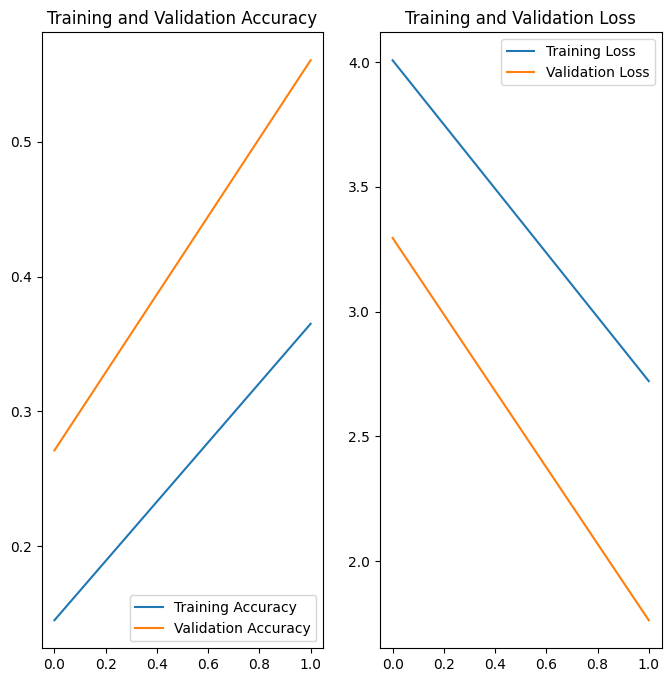

In [27]:
# acc = history4.history['sparse_categorical_accuracy']
# val_acc = history4.history['val_sparse_categorical_accuracy']

# loss = history4.history['sparse_categorical_crossentropy']
# val_loss = history4.history['val_loss']

acc = history4.history['sparse_categorical_accuracy']
val_acc = history4.history['val_sparse_categorical_accuracy']

loss = history4.history['loss']
val_loss = history4.history['val_loss']


epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Training Model 3

**Now, I have tested the dataset with EfficientNetB7 for a better accuracy**

In [28]:
# Need this line so Google will recite some incantations
# for Turing to magically load the model onto the TPU
with strategy.scope():
    enet =efn2.EfficientNetB7(
        input_shape=(512, 512, 3),
        weights='noisy-student',
        include_top=False
    )

    model = tf.keras.Sequential([
        enet,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(len(CLASSES), activation='softmax')
    ])
        
model.compile(
    optimizer=tf.keras.optimizers.Adam(lr=0.0001),
    loss = 'sparse_categorical_crossentropy',
    metrics=['sparse_categorical_accuracy']
)
model.summary()

258068648/258068648 [==============================] - 1s 0us/step


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnet-b7 (Functiona  (None, 16, 16, 2560)      64097680  
 l)                                                              
                                                                 
 global_average_pooling2d_1  (None, 2560)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_4 (Dense)             (None, 104)               266344    
                                                                 
Total params: 64364024 (245.53 MB)
Trainable params: 64053304 (244.34 MB)
Non-trainable params: 310720 (1.19 MB)
_________________________________________________________________


**Here the model has been modified so that the validation accuracy can also be printed**

In [29]:
#scheduler = tf.keras.callbacks.ReduceLROnPlateau(patience=3, verbose=1)

history = model.fit(get_training_dataset(), 
    steps_per_epoch=STEPS_PER_EPOCH,
    epochs=EPOCHS,
    callbacks=[lr_callback],
#     validation_data=None if SKIP_VALIDATION else get_validation_dataset()
    validation_data=get_validation_dataset()
)


Epoch 1: LearningRateScheduler setting learning rate to 1e-05.
Epoch 1/2


2023-11-11 22:12:23.721329: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/AssignAddVariableOp.


128/128 [==============================] - ETA: 0s - loss: 4.5494 - sparse_categorical_accuracy: 0.0673

2023-11-11 22:18:02.665631: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


128/128 [==============================] - 455s 2s/step - loss: 4.5494 - sparse_categorical_accuracy: 0.0673 - val_loss: 4.5392 - val_sparse_categorical_accuracy: 0.0981 - lr: 1.0000e-05

Epoch 2: LearningRateScheduler setting learning rate to 8.8e-05.
Epoch 2/2
128/128 [==============================] - 179s 1s/step - loss: 3.0573 - sparse_categorical_accuracy: 0.3566 - val_loss: 1.7368 - val_sparse_categorical_accuracy: 0.6544 - lr: 8.8000e-05


**The below whole code has been written by me so that the plots between each accuracy and losses can be made using the matplotlib**

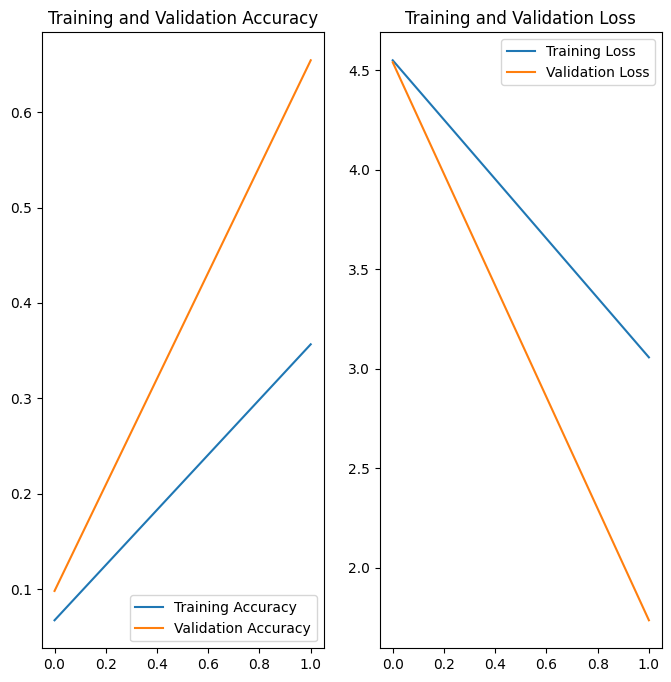

In [30]:
acc = history.history['sparse_categorical_accuracy']
val_acc = history.history['val_sparse_categorical_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']



epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Training Model 4

**Same like efficient net , the dataset has been tested with DenseNet Model.hole code has been modified by me. After that just like in previous model, validation accuracies and losses has been printed. And then finally all the results has been printed using the matplotlib.**

In [31]:
with strategy.scope():
    rnet = DenseNet201(
        input_shape=(512, 512, 3),
        weights='imagenet',
        include_top=False
    )

    model2 = tf.keras.Sequential([
        rnet,
        tf.keras.layers.GlobalAveragePooling2D(),
         tf.keras.layers.Normalization(),
        tf.keras.layers.Dense(len(CLASSES), activation='softmax')
    ])
        
model2.compile(
    optimizer=tf.keras.optimizers.Adam(lr=0.0001),
    loss = 'sparse_categorical_crossentropy',
    metrics=['sparse_categorical_accuracy']
)
model2.summary()

74836368/74836368 [==============================] - 0s 0us/step


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet201 (Functional)    (None, 16, 16, 1920)      18321984  
                                                                 
 global_average_pooling2d_2  (None, 1920)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 normalization_2 (Normaliza  (None, 1920)              3841      
 tion)                                                           
                                                                 
 dense_5 (Dense)             (None, 104)               199784    
                                                                 
Total params: 18525609 (70.67 MB)
Trainable params: 18292712 (69.78 MB)
Non-trainable params: 232897 (909.76 KB)
_________________________________________________________________


In [32]:
history2 = model2.fit(
    get_training_dataset(), 
    steps_per_epoch=STEPS_PER_EPOCH,
    epochs=EPOCHS, 
    callbacks=[lr_callback],
#     validation_data=None if SKIP_VALIDATION else get_validation_dataset()
    validation_data=get_validation_dataset()

    
)


Epoch 1: LearningRateScheduler setting learning rate to 1e-05.
Epoch 1/2


2023-11-11 22:24:32.646647: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/AssignAddVariableOp.


128/128 [==============================] - ETA: 0s - loss: 3.9498 - sparse_categorical_accuracy: 0.1727

2023-11-11 22:28:29.380333: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


128/128 [==============================] - 338s 1s/step - loss: 3.9498 - sparse_categorical_accuracy: 0.1727 - val_loss: 3.4863 - val_sparse_categorical_accuracy: 0.3033 - lr: 1.0000e-05

Epoch 2: LearningRateScheduler setting learning rate to 8.8e-05.
Epoch 2/2
128/128 [==============================] - 122s 953ms/step - loss: 1.6552 - sparse_categorical_accuracy: 0.6547 - val_loss: 0.7846 - val_sparse_categorical_accuracy: 0.8036 - lr: 8.8000e-05


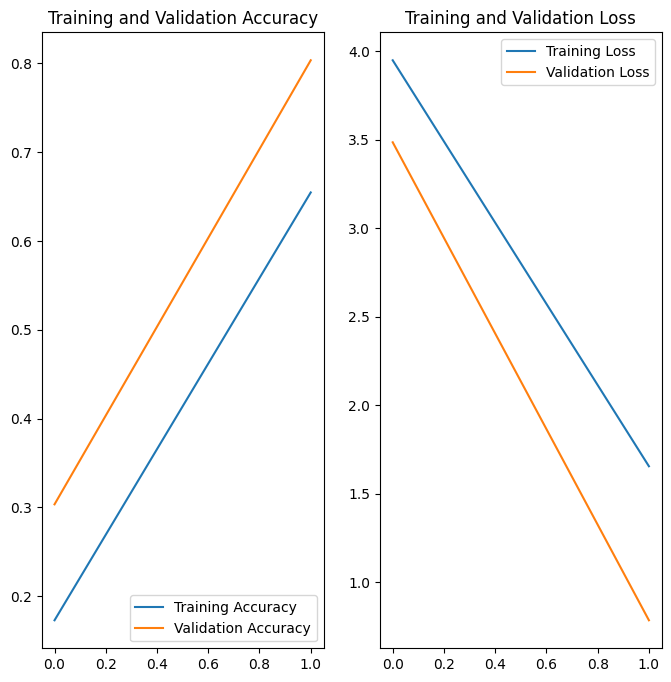

In [33]:
acc = history2.history['sparse_categorical_accuracy']
val_acc = history2.history['val_sparse_categorical_accuracy']

loss = history2.history['loss']
val_loss = history2.history['val_loss']



epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [34]:
if not SKIP_VALIDATION:
    display_training_curves(history2.history['loss'], history2.history['val_loss'], 'loss', 211)
    display_training_curves(history2.history['sparse_categorical_accuracy'], history2.history['val_sparse_categorical_accuracy'], 'accuracy', 212)

**Storing all the training accuracies**

In [43]:
train_accuracies=[]
train_accuracies = [history6.history['sparse_categorical_accuracy'], 
                    history4.history['sparse_categorical_accuracy'], 
                    history.history['sparse_categorical_accuracy'],
                    history2.history['sparse_categorical_accuracy']]


In [44]:
train_accuracies

[[0.0611572265625, 0.14727783203125],
 [0.14508056640625, 0.36492919921875],
 [0.06732177734375, 0.35662841796875],
 [0.1727294921875, 0.65472412109375]]

**Storing all the validation accuracies**

In [39]:
val_accuracies=[]
#Training Model-1
val_accuracies.append(history6.history['val_sparse_categorical_accuracy'])
#Training Model-2
val_accuracies.append(history4.history['val_sparse_categorical_accuracy'])
#Training Model-3
val_accuracies.append(history.history['val_sparse_categorical_accuracy'])
#Training Model-4
val_accuracies.append(history2.history['val_sparse_categorical_accuracy'])


In [40]:
val_accuracies

[[0.08135776221752167, 0.19585129618644714],
 [0.27101293206214905, 0.5603448152542114],
 [0.09806034713983536, 0.6543642282485962],
 [0.30334052443504333, 0.8036099076271057]]

# Comparing all training accuracies and validation accuracies of 4 models

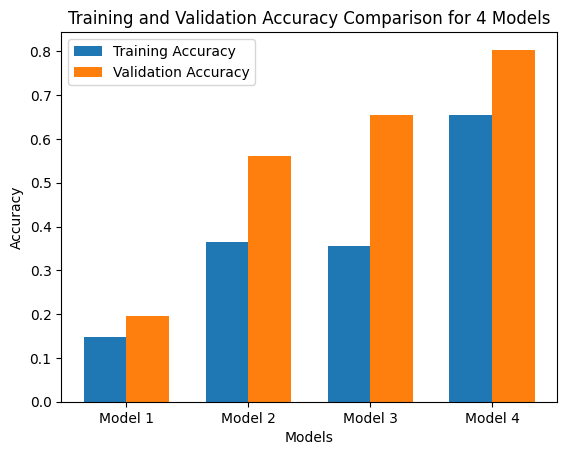

In [45]:
models = ['Model 1', 'Model 2', 'Model 3', 'Model 4']

# Extract the last epoch accuracy for each model
train_last_epoch_acc = [acc[-1] for acc in train_accuracies]
val_last_epoch_acc = [acc[-1] for acc in val_accuracies]

bar_width = 0.35
index = np.arange(len(models))

plt.bar(index, train_last_epoch_acc, bar_width, label='Training Accuracy')
plt.bar(index + bar_width, val_last_epoch_acc, bar_width, label='Validation Accuracy')

plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy Comparison for 4 Models')
plt.xticks(index + bar_width / 2, models)
plt.legend()

plt.show()